In [1]:
# Load the dataset in memory and explore its head and shape to understand how the informations are placed inside of it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
# import scipy.sparse.linalg

data = pd.read_csv('../lab2/data.csv')
np_data = np.array(data)
# print("Shape of dataset: ", np_data.shape)
# print("Head of dataset (labels): ", np_data[:, 0])

X = np_data[:, 1:]
X = X.T
Y = np_data[:, 0]
d, N = X.shape

digits = [0,6,9]

def extract_sub_dataset(X, Y, digit:int):
    I = (Y == digit)
    return X[:, I], Y[I]


X1, Y1 = extract_sub_dataset(X, Y, digits[0])
X2, Y2 = extract_sub_dataset(X, Y, digits[1])
X3, Y3 = extract_sub_dataset(X, Y, digits[2])

# X, Y = np.concatenate((X1,X2,X3), axis=1), np.concatenate((Y1,Y2,Y3))
# d, N = X.shape

def splitDataset(X,  Y, Ntrain:int):
    idx = np.arange(X.shape[1])
    idx = idx.astype(int)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]
    
    Xtrain = X[:, train_idx]
    Xtest = X[:, test_idx]

    Ytrain = Y[train_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

(X1train, Y1train), (X1test, Y1test) = splitDataset(X1, Y1, int(3*Y1.shape[0]/4))
(X2train, Y2train), (X2test, Y2test) = splitDataset(X2, Y2, int(3*Y2.shape[0]/4))
(X3train, Y3train), (X3test, Y3test) = splitDataset(X3, Y3, int(3*Y3.shape[0]/4))

Xtrain, Ytrain = np.concatenate((X1train, X2train, X3train), axis=1), np.concatenate((Y1train, Y2train, Y3train))
Xtest, Ytest = np.concatenate((X1test, X2test, X3test), axis=1), np.concatenate((Y1test, Y2test, Y3test))
#(Xtrain, Ytrain), (Xtest, Ytest) = splitDataset(X, Y, int(3*N/4))
# print("Shape of Xs: ", Xtrain.shape, Xtest.shape)
# print("Shape of Ys: ", Ytrain.shape, Ytest.shape)

In [2]:
# Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results
# (for k = 2) and the position of the centroid of each cluster

def PCA(X, k):
    #print("Computing PCA")
    d, N = X.shape

    #global centroid
    centroid = np.mean(X, axis=1)
    centroid = np.reshape(centroid, (len(centroid), 1))
    # print("Shape of X: ", X.shape)
    # print("Centroid shape: ", centroid.shape)

    # compute the centered version
    X_c = X - centroid
    #print("X_c shape: ", X_c.shape)

    #print("computing svd")
    # global U
    U, s, VT = np.linalg.svd(X_c, full_matrices=False)

    #print("U shape: ", U.shape, "\ns shape: ", s.shape, "\nVT shape: ", VT.shape)

    # projected dataset
    Zk = U[:, :k].T@X_c
    #print("Zk shape: ", Zk.shape)
    return centroid, U[:, :k], s, VT, Zk


def X_kc(datapoint):
    centroidK = np.mean(datapoint, axis=1)
    centroidK = np.reshape(centroidK, (len(centroidK), 1))
    X_kc = datapoint - centroidK
    return centroidK, X_kc


def LDA(X, k, Xs):
    # global C1, C2, C3, X1c, X2c, X3c
    #print("computing LDA")
    C1, X1c = X_kc(Xs[0])
    C2, X2c = X_kc(Xs[1])
    C3, X3c = X_kc(Xs[2])

    Xw = np.concatenate((X1c, X2c, X3c), axis=1)
    Sw = Xw @ Xw.T

    # Compute the Xbars
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)

    # Compute the between-cluster dataset
    Xbar = np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)

    # Global centroid
    C = np.mean(X, axis=1)
    
    # Compute the between-cluster centered dataset
    Xbarc = Xbar - C.reshape((d, 1))

    # Compute the between-cluster scatter matrix
    Sb = Xbarc @ Xbarc.T
    
    # We want to compute the Cholesky decomposition of Sw
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)

    # Compute the first k eigenvector decomposition of L^-1 Sb L
    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k)
    W = np.real(W)

    # Compute Q
    # global Q
    Q = np.linalg.inv(L).T @ W

    # Compute the projection
    Z = Q.T @ X
    return Q, Z, C1, C2, C3


In [3]:
# For both the algorithms, compute for each cluster the average distance from the centroid

def distanceCluster(X, Xc):
    return np.mean(np.linalg.norm(X-Xc, axis=0))

def classification_algorithmPCA(X, centroid):
    res = []
    for i in range(X.shape[1]):
        d1 = distanceCluster(X[:, i:i+1], centroid)
        d2 = distanceCluster(X[:, i:i+1], centroid)
        d3 = distanceCluster(X[:, i:i+1], centroid)
        if d1 == min(d1,d2,d3):
            res.append(digits[0])
        else:
            if d2 == min(d1,d2,d3):
                res.append(digits[1])
            else:
                res.append(digits[2])
    return res

def classification_algorithmLDA(X, C1, C2, C3):
    res = []
    for i in range(X.shape[1]):
        d1 = distanceCluster(X[:, i:i+1], C1)
        d2 = distanceCluster(X[:, i:i+1], C2)
        d3 = distanceCluster(X[:, i:i+1], C3)
        if d1 == min(d1,d2,d3):
            res.append(digits[0])
        else:
            if d2 == min(d1,d2,d3):
                res.append(digits[1])
            else:
                res.append(digits[2])
    return res

def accuracy(classification, labels):
    ok = 0
    for i in range(len(classification)):
        if (classification[i] == labels[i]):
            ok += 1
    return ok*100/len(classification)


Execution for k=2


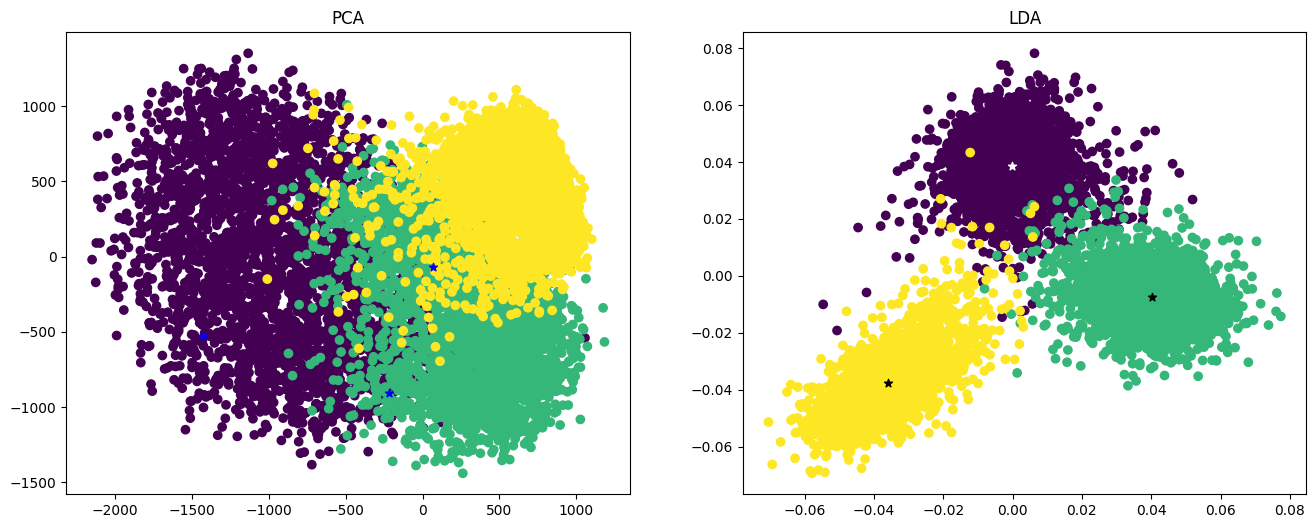

Distances of the training set PCA:
C1:  725.7450816895267
C2:  530.4796193111546
C3:  358.6504568933832
LDA
C1:  0.012605449043504163
C2:  0.011844370832010688
C3:  0.012156083280873076

Distances of the test set PCA:
C1:  736.9673944148212
C2:  545.7997314183993
C3:  364.7919581779048
LDA
C1:  0.014651526339819095
C2:  0.01314404522418612
C3:  0.014142485313978772
Accuracy train PCA: 85.26011560693641
Accuracy train LDA: 98.886748019696
Accuracy test PCA: 84.01284109149277
Accuracy test LDA: 97.75280898876404


In [4]:
def execPCAandLDA(Xtrain, Ytrain, Xtest, Ytest, Xs, k):
    print(f"Execution for k={k}")

    centroid, U, s, VT, P = PCA(Xtrain, k)
    Q, L, C1, C2, C3 = LDA(Xtrain, k, Xs)

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)

    plt.scatter(P[0, :], P[1, :], c=Ytrain)
    pc1 = U.T @ C1
    #print(P.shape, U.T.shape, C1.shape, a1.shape, Y1.shape)
    plt.scatter(pc1[0, :], pc1[1, :], c ='blue', marker='*')
    pc2 = U.T @ C2
    plt.scatter(pc2[0, :], pc2[1, :], c ='blue', marker='*')
    pc3 = U.T @ C3
    plt.scatter(pc3[0, :], pc3[1, :], c ='blue', marker='*')
    plt.title("PCA")
    #plt.show()

    plt.subplot(1,2,2)

    plt.scatter(L[0, :], L[1, :], c=Ytrain)
    plt.title("LDA")
    lc1 = Q.T @ C1
    #print(P.shape, U.T.shape, C1.shape, a1.shape, Y1.shape)
    plt.scatter(lc1[0, :], lc1[1, :], c ='white', marker='*')
    lc2 = Q.T @ C2
    plt.scatter(lc2[0, :], lc2[1, :], c ='black', marker='*')
    lc3 = Q.T @ C3
    plt.scatter(lc3[0, :], lc3[1, :], c ='black', marker='*')
    
    #print(lc1, lc2, lc3, pc1, pc2, pc3, sep='\n\n')
    plt.show()

    #print(f"shape of U.T: {U.T.shape}, shape of Q.T: {Q.T.shape}")

    centroidPCAspace = U.T@centroid

    print("Distances of the training set PCA:")
    print("C1: ", distanceCluster(U.T@X1train, pc1))
    print("C2: ", distanceCluster(U.T@X2train, pc2))
    print("C3: ", distanceCluster(U.T@X3train, pc3))
    print("LDA")
    print("C1: ", distanceCluster(Q.T@X1train, lc1))
    print("C2: ", distanceCluster(Q.T@X2train, lc2))
    print("C3: ", distanceCluster(Q.T@X3train, lc3))

    print("\nDistances of the test set PCA:")
    print("C1: ", distanceCluster(U.T@X1test, pc1))
    print("C2: ", distanceCluster(U.T@X2test, pc2))
    print("C3: ", distanceCluster(U.T@X3test, pc3))
    print("LDA")
    print("C1: ", distanceCluster(Q.T@X1test, lc1))
    print("C2: ", distanceCluster(Q.T@X2test, lc2))
    print("C3: ", distanceCluster(Q.T@X3test, lc3))

    print(f"Accuracy train PCA: {accuracy(classification_algorithmLDA(U.T@Xtrain, pc1, pc2, pc3), Ytrain)}")
    print(f"Accuracy train LDA: {accuracy(classification_algorithmLDA(Q.T@Xtrain, lc1, lc2, lc3), Ytrain)}")
    print(f"Accuracy test PCA: {accuracy(classification_algorithmLDA(U.T@Xtest, pc1, pc2,pc3), Ytest)}")
    print(f"Accuracy test LDA: {accuracy(classification_algorithmLDA(Q.T@Xtest, lc1, lc2, lc3), Ytest)}")


execPCAandLDA(Xtrain, Ytrain, Xtest, Ytest, [X1train, X2train, X3train], k=2)


Execution for k=50


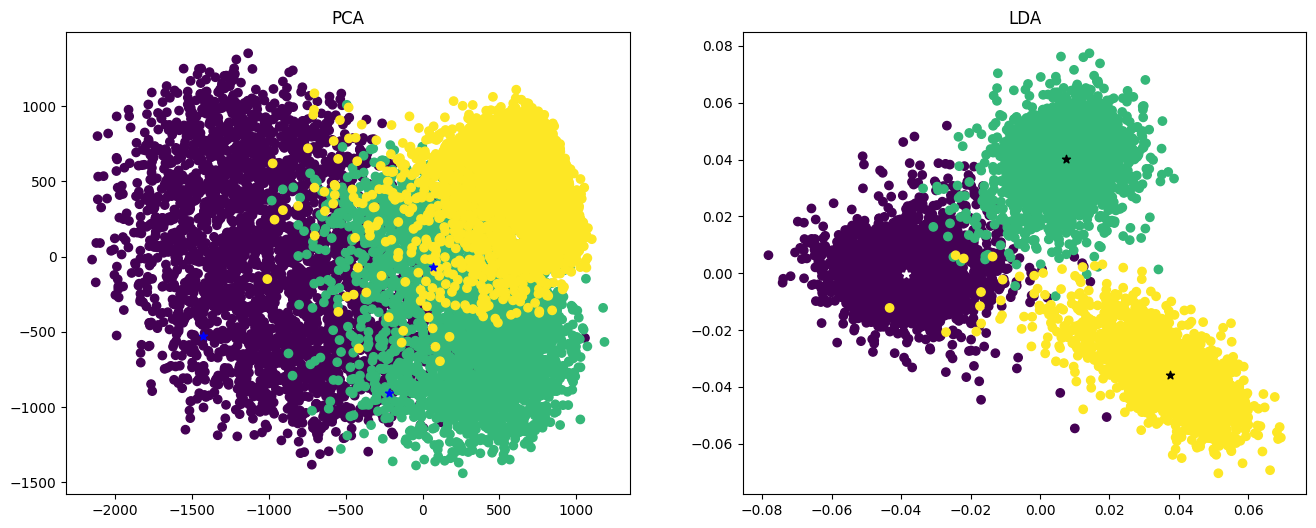

Distances of the training set PCA:
C1:  1637.0048314969104
C2:  1507.6663841003076
C3:  1400.5058992099898
LDA
C1:  0.012695859650057349
C2:  0.011926482874973453
C3:  0.0122264866759955

Distances of the test set PCA:
C1:  1632.4037877701883
C2:  1510.324423101593
C3:  1409.218475451868
LDA
C1:  280.29840365512905
C2:  5.493527315151898
C3:  1530.1569113638861
Accuracy train PCA: 95.7931920359666
Accuracy train LDA: 98.886748019696
Accuracy test PCA: 95.12038523274478
Accuracy test LDA: 97.62439807383628


In [5]:
execPCAandLDA(Xtrain, Ytrain, Xtest, Ytest, [X1train, X2train, X3train], k=50)

Execution for k=150


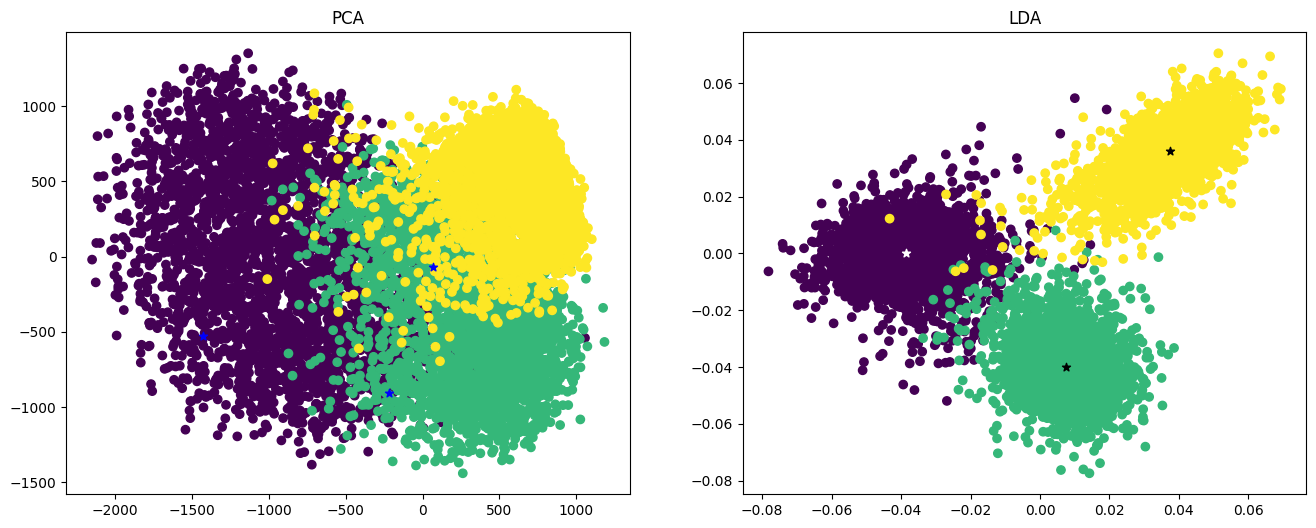

Distances of the training set PCA:
C1:  1742.747317244737
C2:  1617.5090178506255
C3:  1512.1604561606264
LDA
C1:  0.013191402334390754
C2:  0.012327166498264546
C3:  0.012570229955591873

Distances of the test set PCA:
C1:  1738.7723287098959
C2:  1620.9006766397863
C3:  1523.5892562967438
LDA
C1:  416.312823806826
C2:  10.370037884113987
C3:  2445.1877562568898
Accuracy train PCA: 95.81460072789552
Accuracy train LDA: 98.886748019696
Accuracy test PCA: 95.12038523274478
Accuracy test LDA: 97.43178170144462


In [6]:
execPCAandLDA(Xtrain, Ytrain, Xtest, Ytest, [X1train, X2train, X3train], k=150)